In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/ieee-fraud-detection/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# 1. Data Loading

First, let's load the datasets from Kaggle's input directory.

In [3]:
df_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [4]:
print(f'Dimensions of the Transaction data set: {df_transaction.shape}')
print(f'Dimensions of the Identity data set: {df_identity.shape}')

Dimensions of the Transaction data set: (590540, 394)
Dimensions of the Identity data set: (144233, 41)


Notice that the number of features in the identity dataset is much smaller (41) compared to the transaction dataset (394). Therefore, merging the datasets should not have significant computational disadvantages. Also, for better analysis, it seems like a good idea to merge these datasets.

In [5]:
df = pd.merge(df_transaction,df_identity,how="left",on="TransactionID")
print(f'Dimensions of the combined data set: {df.shape}')

Dimensions of the combined data set: (590540, 434)


Examine the merged dataset.

In [6]:
df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Missing Values Analysis

Identify columns with too many missing (NaN) values.

🔍 Columns with missing values (%):
       NaN Ratio  NaN %
id_24   0.991962  99.20
id_25   0.991310  99.13
id_07   0.991271  99.13
id_08   0.991271  99.13
id_21   0.991264  99.13
id_26   0.991257  99.13
id_27   0.991247  99.12
id_23   0.991247  99.12
id_22   0.991247  99.12
dist2   0.936284  93.63
D7      0.934099  93.41
id_18   0.923607  92.36
D13     0.895093  89.51
D14     0.894695  89.47
D12     0.890410  89.04
id_03   0.887689  88.77
id_04   0.887689  88.77
D6      0.876068  87.61
id_33   0.875895  87.59
id_10   0.873123  87.31


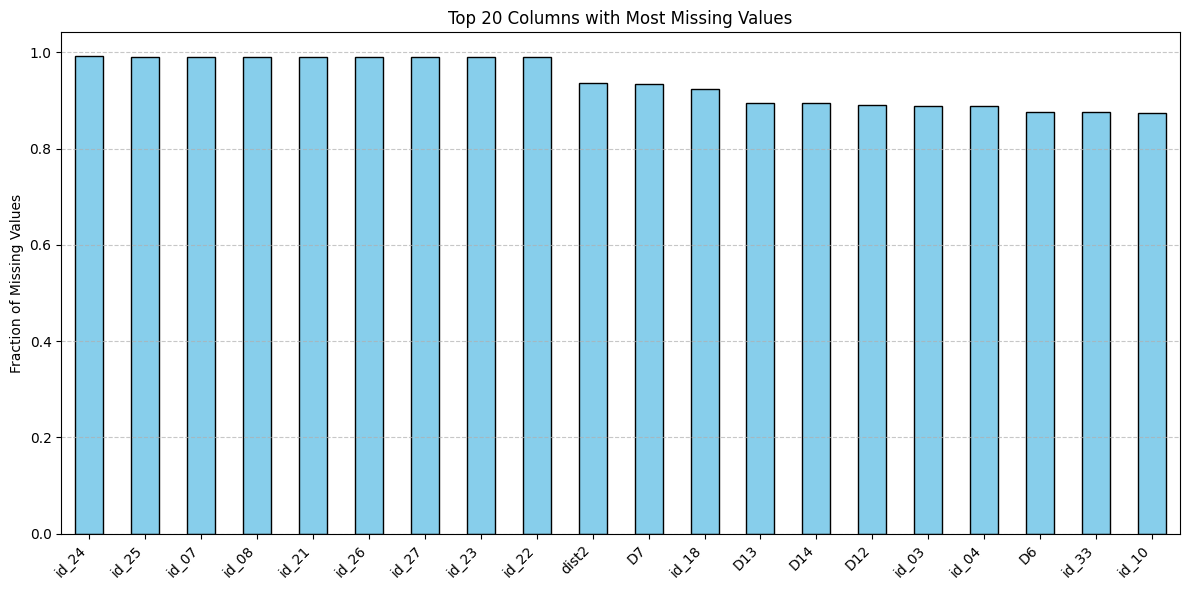

In [7]:
nan_columns_ratio = df.isnull().mean().sort_values(ascending=False)
nan_columns_ratio = nan_columns_ratio[nan_columns_ratio > 0]
nan_df = nan_columns_ratio.to_frame(name="NaN Ratio")
nan_df["NaN %"] = (nan_df["NaN Ratio"] * 100).round(2)
print("🔍 Columns with missing values (%):")
print(nan_df.head(20))
top_n = 20
plt.figure(figsize=(12, 6))
nan_columns_ratio.head(top_n).plot(kind="bar", color="skyblue", edgecolor="black")
plt.ylabel("Fraction of Missing Values")
plt.title(f"Top {top_n} Columns with Most Missing Values")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Check what threshold for dropping NaNs should be by plotting a graph of the threshold versus the number of remaining columns.

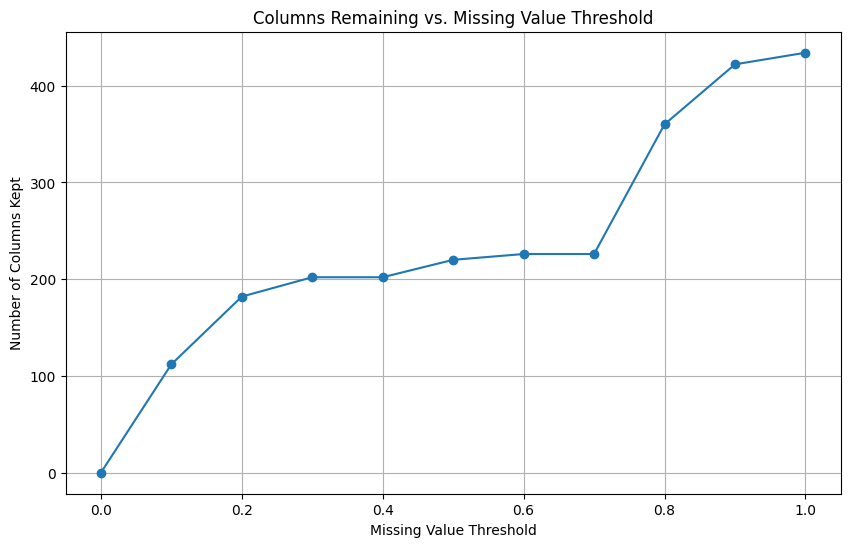

In [8]:
thresholds = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
columns_remaining = [(df.isnull().mean() < t).sum() for t in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, columns_remaining, marker='o')
plt.title("Columns Remaining vs. Missing Value Threshold")
plt.xlabel("Missing Value Threshold")
plt.ylabel("Number of Columns Kept")
plt.grid(True)
plt.show()


 A threshold of 0.8 seems to be the best choice. For a more aggressive approach, one might consider 0.7.

In [9]:
nan_columns_ratio = df.isnull().mean().sort_values(ascending=False)
columns_with_high_nan = nan_columns_ratio[nan_columns_ratio > 0.8].index
columns_with_high_nan

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23',
       'id_22', 'dist2', 'D7', 'id_18', 'D13', 'D14', 'D12', 'id_03', 'id_04',
       'D6', 'id_33', 'id_10', 'id_09', 'D9', 'D8', 'id_30', 'id_32', 'id_34',
       'id_14', 'V142', 'V158', 'V140', 'V162', 'V141', 'V161', 'V157', 'V146',
       'V156', 'V155', 'V154', 'V153', 'V149', 'V147', 'V148', 'V163', 'V139',
       'V138', 'V160', 'V151', 'V152', 'V145', 'V144', 'V143', 'V159', 'V164',
       'V165', 'V166', 'V150', 'V337', 'V333', 'V336', 'V335', 'V334', 'V338',
       'V339', 'V324', 'V332', 'V325', 'V330', 'V329', 'V328', 'V327', 'V326',
       'V322', 'V323', 'V331'],
      dtype='object')

In [10]:
print(columns_with_high_nan.shape)

(74,)


## 3. Target Variable

Let’s examine the distribution of the target variable.

Fraud rate: 3.50%


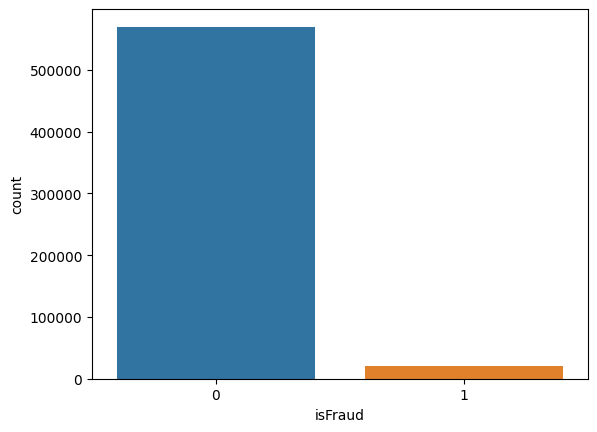

In [11]:
print(f"Fraud rate: {df['isFraud'].mean():.2%}")
sns.countplot(x='isFraud', data=df);

As we can see, the dataset is highly imbalanced. This implies that some form of weighting or downsampling will be necessary during training. Additionally, the most appropriate evaluation metrics are Precision/Recall, F1-score, and Kappa.

# 4. Target vs Some Other Features

One of the most interesting features is the amount of money in the transaction. Hence, we will plot Freud vs Transaction Amount graph.

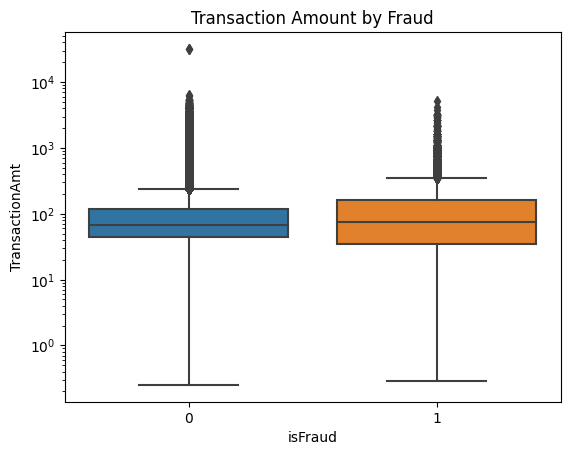

In [12]:
sns.boxplot(x='isFraud', y='TransactionAmt', data=df)
plt.yscale('log') 
plt.title('Transaction Amount by Fraud')
plt.show()

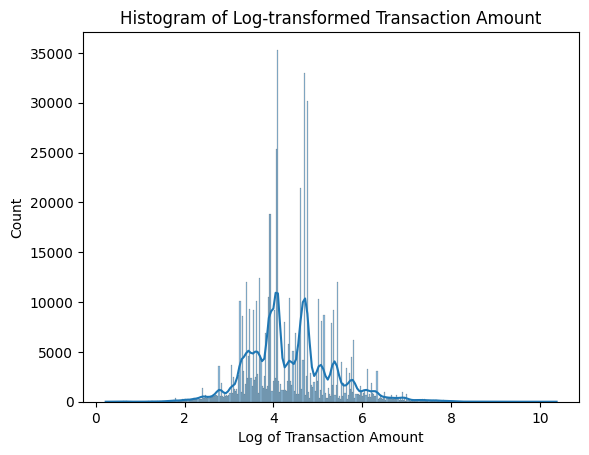

In [13]:
df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
sns.histplot(df['TransactionAmt_log'], kde=True)
plt.title('Histogram of Log-transformed Transaction Amount')
plt.xlabel('Log of Transaction Amount')
plt.ylabel('Count')
plt.show()

The hour of the day is also an important feature to consider.

In [14]:
df['Hour'] = pd.to_datetime(df['TransactionDT'], unit='s').dt.hour
df['Hour'].dtype

dtype('int32')

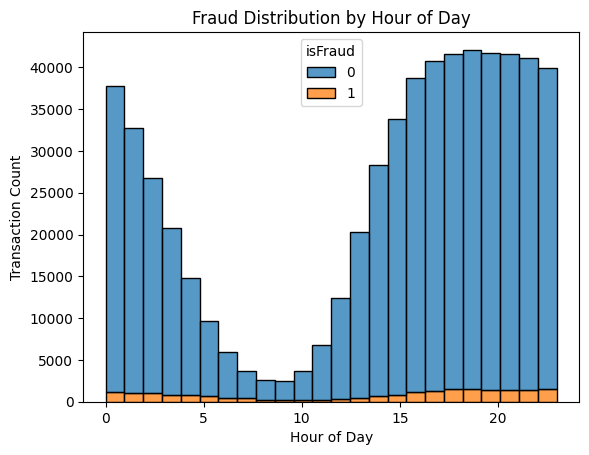

In [15]:
sns.histplot(data=df, x='Hour', hue='isFraud', bins=24, multiple='stack')
plt.title('Fraud Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Transaction Count')
plt.show()

Now, let's consider ratio graphs instead.

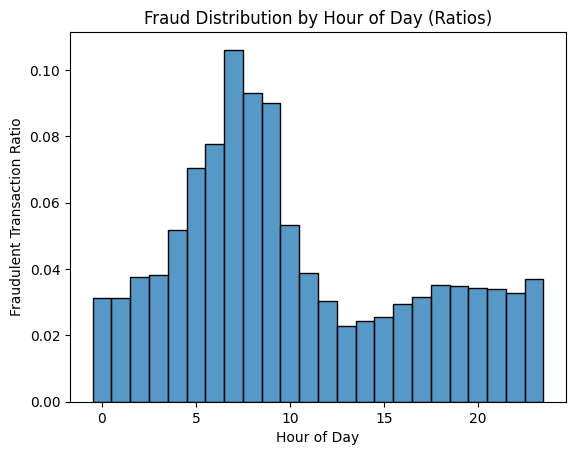

In [16]:
# Calculate the ratio of fraudulent transactions for each hour
fraud_ratio_by_hour = df.groupby('Hour')['isFraud'].mean()

# Create a new DataFrame for plotting
plot_data = fraud_ratio_by_hour.reset_index()

# Plot the fraud ratio using sns.histplot
sns.histplot(data=plot_data, x='Hour', weights='isFraud', bins=24, discrete=True, multiple='stack')

# Customizing the plot
plt.title('Fraud Distribution by Hour of Day (Ratios)')
plt.xlabel('Hour of Day')
plt.ylabel('Fraudulent Transaction Ratio')
plt.show()


Examine the email domains and card type as well.

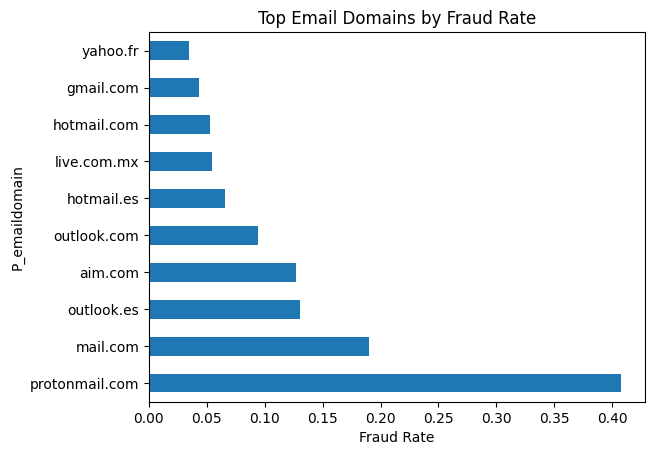

In [17]:
email_fraud = df.groupby('P_emaildomain')['isFraud'].mean().sort_values(ascending=False).head(10)
email_fraud.plot(kind='barh', title='Top Email Domains by Fraud Rate')
plt.xlabel('Fraud Rate')
plt.show()

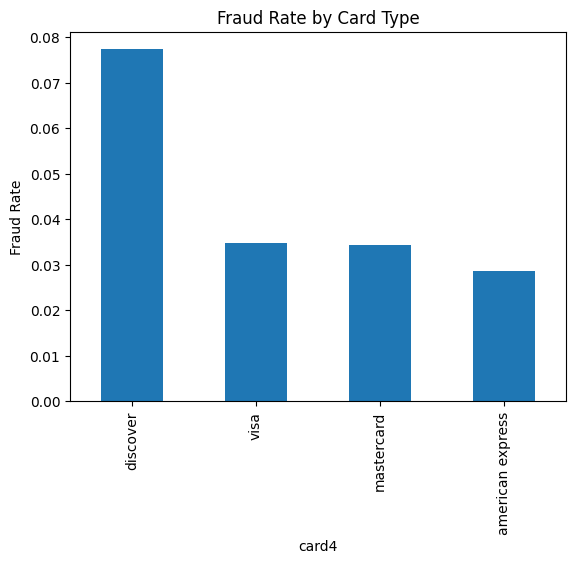

In [18]:
fraud_rate = df.groupby('card4')['isFraud'].mean().sort_values(ascending=False)
fraud_rate.plot(kind='bar', title='Fraud Rate by Card Type')
plt.ylabel('Fraud Rate')
plt.show()